In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.feature_selection import chi2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import ttest_ind
from tabulate import tabulate

# from dtreeviz.trees import dtreeviz

sns.set(style='white', context='notebook', palette='deep')
pd.set_option('display.max_columns', None)
np.random.seed(2)

In [2]:
random_seed = 2
y_type = 'NSP'

In [3]:
df_data = pd.read_excel('CTG.xlsx', sheet_name="Data", header=1)
df_data = df_data[0:-3]
df_data=df_data.set_index(np.arange(2126)+1)

df = pd.read_excel('CTG.xlsx', sheet_name="Raw Data")
df = df[1:-3] # delete empty rows
df = df.drop(['FileName'], axis=1) # delete FileName column
df = df.drop(['SegFile'], axis=1) # delete SegFile column
df = df.drop(['LBE'], axis=1) # delete LBE column (repeated LB column)
df = df.drop(['DR'], axis=1) # delete DR column (everything is zero)
a= df_data['AC.1']
df['AC'] = df_data['AC.1']
df['FM'] = df_data['FM.1']
df['UC'] = df_data['UC.1']
df['DL'] = df_data['DL.1']
df['DS'] = df_data['DS.1']
df['DP'] = df_data['DP.1']

df = df[['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV',  'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 
         'Median', 'Variance', 'Tendency', 'CLASS', 'NSP']]

df['Nmax'] = df['Nmax'].astype(int)
df['Nzeros'] = df['Nzeros'].astype(int)
df['CLASS'] = df['CLASS'].astype(int)
df['NSP'] = df['NSP'].astype(int)

In [4]:
X_df = df.drop(['CLASS','NSP'],axis=1)
y = df[y_type]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)

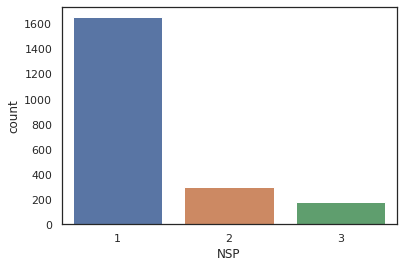

In [5]:
g = sns.countplot(x=y)

## Chi 2

In [6]:
X_edit = X_df.copy()
X_edit['Tendency'] += 1 # ponieważ Tendency to -1 lub 0 lub 1, a test chi_2 nie akceptuje ujemnych liczb

In [7]:
chi_scores = chi2(X_edit,y)
chi_2 = pd.Series(chi_scores[0],index = X_edit.columns)
chi_2.sort_values(ascending = False , inplace = True)
df_chi = pd.DataFrame(data={'Cecha': chi_2.index, 'Wartosc': chi_2.values})
df_chi['Cecha str'] = [str(int) for int in chi_2.index]
df_chi[['Cecha','Wartosc']].head()

,Cecha,Wartosc
0,ALTV,17921.988734
1,Variance,11801.125508
2,ASTV,3270.412869
3,Width,2258.452116
4,Min,1508.513834


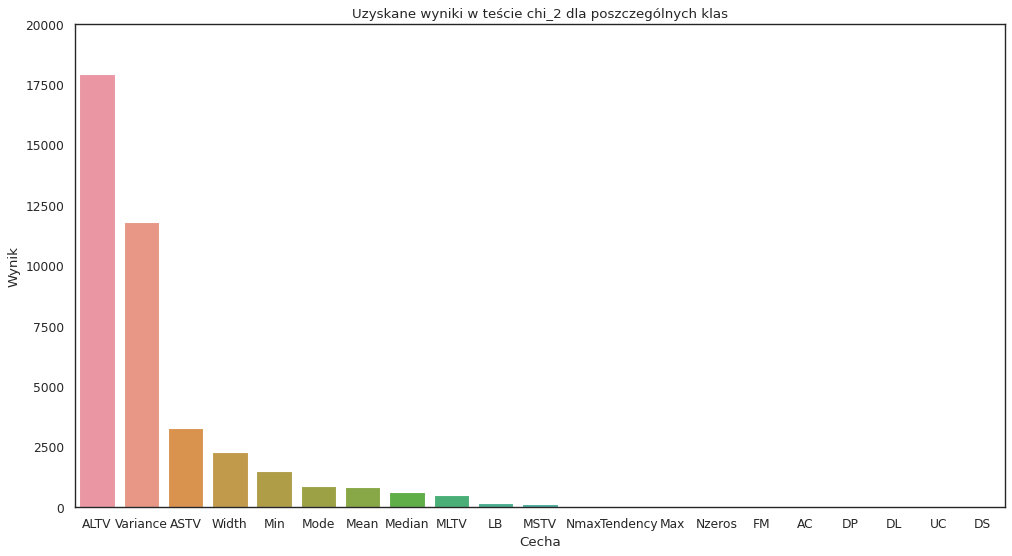

In [8]:
plt.figure(figsize=(15, 8), dpi=80)
plt.title('Uzyskane wyniki w teście chi_2 dla poszczególnych klas')
plt.ylim(0, 20000)
string_index = [str(int) for int in chi_2.index]
sns.barplot(y='Wartosc', x='Cecha str', data=df_chi);
plt.xlabel("Cecha")
plt.ylabel("Wynik")
plt.show()

In [12]:
X_df = X_df[['ALTV', 'Variance', 'ASTV']]

In [13]:
def generate_u0(c,n):
    u0= []
    for i in range(c):
        u0.append([])
        for j in range(n):
            if i==j or i==j%c:
                u0[i].append(1)
            else:
                u0[i].append(0)
    return u0

In [14]:
def generate_vt(u, x, c, n, p, m):
    v=[]
    for i in range(c):
        v.append([])
        for j in range(p):
            v_ij=sum((u[i][k]**m)*x[k][j] for k in range(n))/sum(u[i][k]**m for k in range(n))
            v[i].append(v_ij)
    return v

In [15]:
def calculate_d(x,v, c, n):
    d=[]
    for i in range(c):
        d.append([])
        for k in range(n):           
            d[i].append(np.linalg.norm(abs(np.subtract(x[k],v[i]))))
    return d

In [16]:
def generate_u(d, m, c, n):
    d_eps = 1e-6
    u=[]
    for i in range(c):
        u.append([])
        for k in range(n):
            u_sum=0
            different=False
            for s in range(c):
                if d[s][k]==0:
                    d[s][k] += d_eps
                #     different=True
                #     break
                u_sum+=(d[i][k]/d[s][k])**(2/(m-1))
            if not different:
                u[i].append(1/u_sum)                  
    return u

In [17]:
def delta_u(u1, u2, c, n):
    return sum(sum(np.linalg.norm(np.subtract(u2[i][k], u1[i][k])) for k in range(n)) for i in range(c))

In [18]:
X_df

,ALTV,Variance,ASTV
1,43.0,73.0,73.0
2,0.0,12.0,17.0
3,0.0,13.0,16.0
4,0.0,13.0,16.0
5,0.0,11.0,16.0
...,...,...,...
2122,25.0,2.0,79.0
2123,22.0,3.0,78.0
2124,20.0,4.0,79.0
2125,27.0,4.0,78.0


In [19]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2,init='random').fit_transform(X_df)

In [20]:
def plot_tsne(y, c=3):
    df_tsne = pd.DataFrame()
    df_tsne['tsne-2d-one'] = X_embedded[:,0]
    df_tsne['tsne-2d-two'] = X_embedded[:,1]
    df_tsne['y'] = y
    
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sns.color_palette("hls", c),
        data=df_tsne,
        legend="full"
    );

In [21]:
y.unique().shape[0]

3

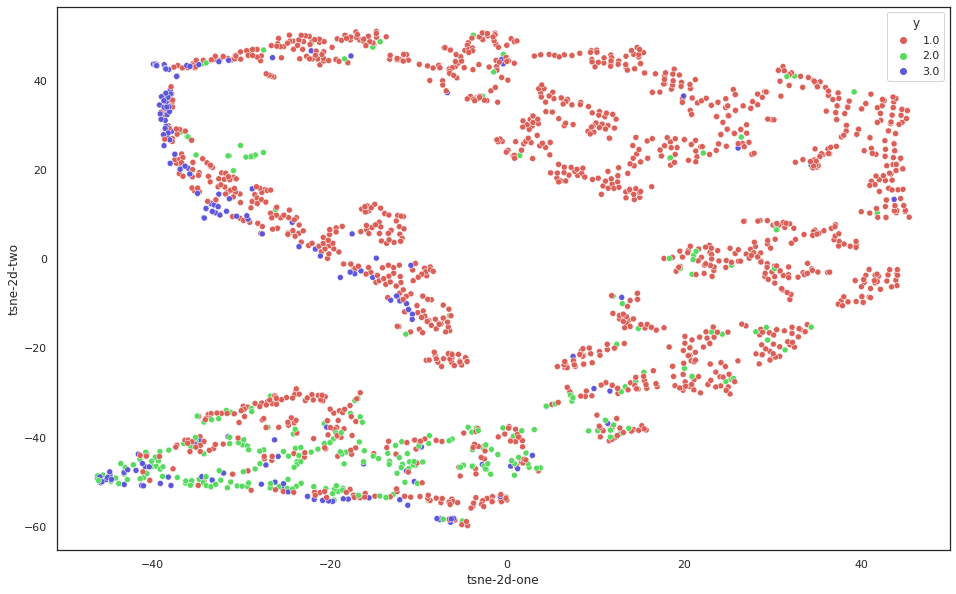

In [22]:
plot_tsne(y, y.unique().shape[0])

In [23]:
def generate_vt(u, x, c, n, p, m):
    v=[]
    for i in range(c):
        v.append([])
        for j in range(p):
            v_ij=sum((u[i][k]**m)*x[k][j] for k in range(n))/sum(u[i][k]**m for k in range(n))
            v[i].append(v_ij)
    return v

In [25]:
plot_tsne(y)
X = df.drop(['CLASS','NSP'],axis=1).values
p=X.shape[1]
n=X.shape[0]
epsilon = 1e-5

m=2
for c in range(3,10):
    u_old=generate_u0(c,n)
    d_u = 2*epsilon
    while epsilon<d_u:
        v = generate_vt(u_old,X,c,n,p,m)
        d = calculate_d(X,v,c,n)
        u_new = generate_u(d, m, c, n)
        d_u = delta_u(u_old, u_new, c, n)
        u_old = u_new
    plot_tsne(np.array(u_new).argmax(axis=0), c)

In [58]:
unique, counts = np.unique(np.array(u_new).argmax(axis=0), return_counts=True)
np.asarray((unique, counts)).T

array([[  0, 829],
       [  1, 687],
       [  2, 610]])

In [38]:
unique, counts = np.unique(y, return_counts=True)
np.asarray((unique, counts)).T

array([[   1, 1655],
       [   2,  295],
       [   3,  176]])

### Relacje rozmyte

In [91]:
from scipy.spatial.distance import pdist, squareform

def get_q0():
    norm_df = df.drop(['CLASS','NSP'],axis=1)
    norm_df=(norm_df-norm_df.min())/(norm_df.max()-norm_df.min())
    distances = pdist(norm_df.values, metric='minkowski', p=norm_df.shape[1])
    dist_matrix = squareform(distances)
    q_0 = 1 - dist_matrix / dist_matrix.max()
    return q_0

In [92]:
def max_min(matrix):
    result=np.empty_like(matrix)
    for i in range(matrix.shape[0]):
        for k in range(matrix.shape[1]):
            result[i][k]=np.array([matrix[i], matrix[:,k]]).min(axis=0).max()
    return result
                
def calculate(matrix):
    matrix2=max_min(matrix)
    result= np.maximum(matrix,matrix2)
    return result

In [93]:
qn=get_q0()
# qn=m
qm=calculate(qn)
while not (qn==qm).all():
    qn=qm
    qm=calculate(qm)
    print((qn-qm).sum())
print(qm)

-182625.97625336333
-62683.90773415603
-13336.722300487614
-627.146400650163
-0.009255978912724672
0.0
[[1.         0.53076273 0.53076273 ... 0.75229764 0.75229764 0.53076273]
 [0.53076273 1.         0.85111695 ... 0.53076273 0.53076273 0.83822438]
 [0.53076273 0.85111695 1.         ... 0.53076273 0.53076273 0.83822438]
 ...
 [0.75229764 0.53076273 0.53076273 ... 1.         0.94504746 0.53076273]
 [0.75229764 0.53076273 0.53076273 ... 0.94504746 1.         0.53076273]
 [0.53076273 0.83822438 0.83822438 ... 0.53076273 0.53076273 1.        ]]


In [215]:
np.save('qm.npy', qm)

In [216]:
qm = np.load('qm.npy')

In [189]:
for alfa_ciecie in np.arange(0.1,0.9,0.1):
    new_qm = np.where(qm>=alfa_ciecie, 1, 0)
    unique_groups = pd.DataFrame(new_qm).drop_duplicates().values
    claster_list = []
    for i in range(new_qm.shape[0]):
        claster_list.append(np.argwhere((new_qm[i]==unique_groups.tolist()).all(axis=1))[0][0])
    y_pred = np.array(claster_list)
    unique, counts = np.unique(y_pred, return_counts=True)
    print(alfa_ciecie, dict(zip(unique, counts)))

0.1 {0: 2126}
0.2 {0: 2126}
0.30000000000000004 {0: 2126}
0.4 {0: 2119, 1: 2, 2: 5}
0.5 {0: 2118, 1: 1, 2: 2, 3: 5}
0.6 {0: 835, 1: 1100, 2: 13, 3: 7, 4: 4, 5: 154, 6: 1, 7: 2, 8: 1, 9: 2, 10: 5, 11: 2}
0.7000000000000001 {0: 834, 1: 1093, 2: 2, 3: 9, 4: 6, 5: 2, 6: 4, 7: 108, 8: 1, 9: 3, 10: 1, 11: 1, 12: 1, 13: 1, 14: 2, 15: 1, 16: 1, 17: 1, 18: 1, 19: 2, 20: 2, 21: 1, 22: 1, 23: 6, 24: 26, 25: 5, 26: 2, 27: 4, 28: 1, 29: 2, 30: 1, 31: 1}
0.8 {0: 1, 1: 1019, 2: 766, 3: 2, 4: 3, 5: 9, 6: 4, 7: 2, 8: 2, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 2, 17: 1, 18: 1, 19: 1, 20: 4, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 2, 29: 1, 30: 1, 31: 40, 32: 5, 33: 2, 34: 1, 35: 1, 36: 1, 37: 2, 38: 2, 39: 1, 40: 2, 41: 1, 42: 37, 43: 1, 44: 1, 45: 1, 46: 1, 47: 11, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 3, 56: 1, 57: 2, 58: 2, 59: 2, 60: 1, 61: 1, 62: 2, 63: 1, 64: 3, 65: 1, 66: 1, 67: 1, 68: 5, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 2, 78: 1,

In [218]:
# Dunny index